## Kaggle Setup

In [ ]:
import json
import os

token = "Token"

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": "UserName", "key": token}, f)

os.chmod("/root/.kaggle/kaggle.json", 600)


In [2]:
!kaggle datasets download -d ahmeddulaimi/ultimate-arabic-news-dataset


Dataset URL: https://www.kaggle.com/datasets/ahmeddulaimi/ultimate-arabic-news-dataset
License(s): CC-BY-SA-4.0
 81% 302M/372M [00:00<00:00, 857MB/s] 
100% 372M/372M [00:00<00:00, 642MB/s]


In [3]:
!unzip ultimate-arabic-news-dataset.zip

Archive:  ultimate-arabic-news-dataset.zip
  inflating: Original.csv            
  inflating: Original_Without_Stem.csv  
  inflating: Original_Without_Stop.csv  
  inflating: Original_Without_Stop_Stem.csv  
  inflating: UltimateArabic.csv      
  inflating: UltimateArabicPrePos.csv  


## Setup & Imports

In [1]:
%%capture
!pip install rank_bm25 nltk transformers torch

In [2]:
import os
from pathlib import Path

import re
import math
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    stopWords = set(stopwords.words('arabic'))
    if len(stopWords) == 0:
        raise Exception("empty")
except Exception:
    stopWords = set([
        "في", "من", "على", "و", "إلى", "عن", "أن", "مع", "كان", "لدى", "ما", "لا", "هذا", "هذه",
    ])
    print("Warning: Using fallback stopword list. Install NLTK arabic stopwords for full list.")

ar_stemmer = ISRIStemmer()
device = "cuda" if torch.cuda.is_available() else "cpu"


## Data Loading & Preprocessing

In [3]:
df = pd.read_csv("Original.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26995 entries, 0 to 26994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    26995 non-null  object
 1   label   26995 non-null  object
dtypes: object(2)
memory usage: 421.9+ KB


In [4]:
df.head()

,text,label
0,مسرح البولشوي يقيم حفلات موسيقية بمناسبة الذكر...,Art
1,فاه ممثل بريطاني مخضرم سير كريستوفر عمر عاما ت...,Art
2,باولو كويلو يعرض كتبه للقراءة مجاناً قبل الدفع...,Art
3,وفاة أكثر المغنيات الروسيات أناقة (فيديو)\n في...,Art
4,احمد مافيا تجاره اعضا بشريه بمصر يطرح ممثل مصر...,Art


In [5]:
df.describe()

,text,label
count,26995,26995
unique,26645,9
top,اكتشاف مادة خطرة في الشوكولاتة\n بينت نتائج در...,Art
freq,3,3000


In [6]:
df['label'].unique()

array(['Art', 'Culture', 'Economy', 'Medical', 'Politic', 'Religion',
       'Sport', 'Technology', 'Diverse'], dtype=object)

In [7]:
empty_rows = df[df['text'].str.strip() == '']
print("Number of empty rows to be dropped:", len(empty_rows))
df = df[df['text'].str.strip() != ''].reset_index(drop=True)

arabic_diacritics = re.compile(r'[\u064B-\u0652\u0670\u0640]')
_non_arabic = re.compile(r"[^\u0621-\u064A0-9\s]")

def normalize_arabic(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"[إأٱآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ؤ", "ء", text)
    text = re.sub(r"ئ", "ء", text)
    text = re.sub(r"ة", "ه", text)
    return text

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = arabic_diacritics.sub("", text)
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"RT\b", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = _non_arabic.sub(" ", text)
    return re.sub(r"\s+", " ", text).strip()

def remove_stopwords(text: str) -> str:
    return " ".join([t for t in text.split() if t not in stopWords])

def preprocess_text(sentence: str) -> str:
    sentence = normalize_arabic(sentence)
    sentence = clean(sentence)
    sentence = remove_stopwords(sentence)
    return sentence

df['preprocessed'] = df['text'].fillna('').apply(preprocess_text)

docs = pd.DataFrame({
    "docno": df.index,
    "content": df["preprocessed"],
    "original": df["text"],
    "label": df["label"]
})


Number of empty rows to be dropped: 3


## Boolean Retrieval

In [8]:
class BooleanIndex:
    def __init__(self):
        self.index = defaultdict(set)

    def build(self, docs: pd.DataFrame):
        for _, row in docs.iterrows():
            docno = row["docno"]
            text = (row.get("content") or "")
            if not isinstance(text, str) or text.strip() == "":
                continue
            tokens = set([t for t in text.split() if t])
            for t in tokens:
                self.index[t].add(docno)

    def AND(self, q1, q2):
        return self.index.get(q1, set()) & self.index.get(q2, set())

    def OR(self, q1, q2):
        return self.index.get(q1, set()) | self.index.get(q2, set())

    def NOT(self, q, all_docs):
        return all_docs - self.index.get(q, set())


## Ranked Retrieval (TF-IDF)

In [9]:
class ArabicTfidf:
    def __init__(self):
        self.df = defaultdict(int)
        self.N = 0
        self.index = defaultdict(list)

    def tokenize(self, text):
        return text.split()

    def fit(self, docs):
        self.N = len(docs)
        for _, row in docs.iterrows():
            tokens = set(self.tokenize(row.get("content") or ""))
            for t in tokens:
                self.df[t] += 1

    def tfidf_vec(self, text):
        tokens = self.tokenize(text)
        total = max(1, len(tokens))
        counts = defaultdict(int)
        for t in tokens:
            counts[t] += 1

        vec = {}
        for t, c in counts.items():
            if t in self.df:
                tf = c / total
                idf = math.log((self.N + 1) / (self.df[t] + 1)) + 1e-9
                vec[t] = tf * idf
        return vec

    def build_index(self, docs):
        for _, row in docs.iterrows():
            docno = row["docno"]
            vec = self.tfidf_vec(row.get("content") or "")
            for t, w in vec.items():
                self.index[t].append((docno, w))

    def search(self, query, top_n=10):
        qvec = self.tfidf_vec(query)
        scores = defaultdict(float)
        for t, q_w in qvec.items():
            for docno, d_w in self.index.get(t, []):
                scores[docno] += q_w * d_w
        return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]


## Ranked Retrieval (BM25)

In [10]:
class BM25:
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.df = defaultdict(int)
        self.avgdl = 0
        self.index = defaultdict(list)
        self.doc_len = {}
        self.N = 0

    def tokenize(self, text):
        return text.split()

    def fit(self, docs):
        total_len = 0
        N = len(docs)
        for _, row in docs.iterrows():
            docno = row["docno"]
            tokens = self.tokenize(row.get("content") or "")
            dl = len(tokens)
            total_len += dl
            self.doc_len[docno] = dl
            for t in set(tokens):
                self.df[t] += 1
        self.avgdl = total_len / max(1, N)
        self.N = N

    def build_index(self, docs):
        for _, row in docs.iterrows():
            docno = row["docno"]
            tokens = self.tokenize(row.get("content") or "")
            counts = defaultdict(int)
            for t in tokens:
                counts[t] += 1
            for t, f in counts.items():
                self.index[t].append((docno, f))

    def _score_term(self, f, df, dl):
        idf = math.log((self.N - df + 0.5) / (df + 0.5) + 1e-9)
        num = f * (self.k1 + 1)
        den = f + self.k1 * (1 - self.b + self.b * dl / self.avgdl)
        return idf * (num / den)

    def search(self, query, top_n=10):
        scores = defaultdict(float)
        tokens = self.tokenize(query)
        for t in tokens:
            if t not in self.index: continue
            df = self.df[t]
            for docno, f in self.index[t]:
                dl = self.doc_len[docno]
                scores[docno] += self._score_term(f, df, dl)
        return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]


## Query Expansion (Word Embeddings / Stemming)

In [11]:
def expand_query(query: str):
    tokens = query.split()
    expanded = set(tokens)
    for t in tokens:
        stem = ar_stemmer.stem(t)
        if stem:
            expanded.add(stem)
    return " ".join(expanded)

## Neural Re-Ranking (AraBERT)

In [12]:
class AraBERTReRanker:
    def __init__(self, model_name="aubmindlab/bert-base-arabertv02"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

    def embed_text(self, text):
        encoded = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad():
            output = self.model(**encoded)
        emb = self.mean_pooling(output, encoded['attention_mask'])
        return torch.nn.functional.normalize(emb, p=2, dim=1).cpu().numpy().flatten()


## Evaluation & Visualization

In [13]:
def run_example(query_raw, docs_df, ground_truth=None, rerank_topk=20):
    docs_df = docs_df.reset_index(drop=True).copy()
    docs_df["docno"] = docs_df.index.astype(int)
    docs_by_docno = docs_df.set_index("docno", drop=False)

    print("Raw query:", query_raw)
    query = preprocess_text(query_raw)
    print("Preprocessed query:", query)
    expanded = expand_query(query)
    print("Expanded query:", expanded)

    query_docno = None
    matched = docs_df[docs_df["content"] == query]
    if len(matched) > 0:
        query_docno = int(matched["docno"].iloc[0])
        print("Query matched document in collection -> docno:", query_docno)

    bi = BooleanIndex(); bi.build(docs_df)
    tokens = [t for t in query.split() if t]
    boolean_results = set()
    for t in tokens:
        boolean_results |= bi.index.get(t, set())
    print("Boolean results (first 10 docno):", list(boolean_results)[:10])

    tf = ArabicTfidf(); tf.fit(docs_df); tf.build_index(docs_df)
    tfidf_results = tf.search(expanded, top_n=100)
    print("TF-IDF top 5 docno:", [docno for docno, _ in tfidf_results[:5]])

    bm = BM25(); bm.fit(docs_df); bm.build_index(docs_df)
    bm25_results = bm.search(expanded, top_n=100)
    print("BM25 top 5 docno:", [docno for docno, _ in bm25_results[:5]])

    reranker = AraBERTReRanker()
    q_emb = reranker.embed_text(query)

    scored = []
    for docno, _ in bm25_results[:rerank_topk]:
        text = docs_by_docno.loc[docno, "content"]
        d_emb = reranker.embed_text(text)
        sim = float(np.dot(q_emb, d_emb))
        scored.append((docno, sim))

    reranked = sorted(scored, key=lambda x: x[1], reverse=True)
    print("AraBERT re-ranked top:", reranked[:10])

    if ground_truth is None:
        raise ValueError("You must provide a per-query ground_truth={docno:score}")

    true_docs = list(ground_truth.keys())
    if query_docno is not None and query_docno in true_docs:
        true_docs.remove(query_docno)

    if len(true_docs) == 0:
        print("Warning: Ground truth contains no relevant docs after cleanup.")

    true_doc = true_docs[0]

    def get_rank(results, target):
        for i, (docno, _) in enumerate(results):
            if docno == target:
                return i + 1
        return None

    def hit_at_k(results, target, k):
        return 1 if any(doc == target for doc, _ in results[:k]) else 0

    def mrr(results, target):
        r = get_rank(results, target)
        return 1.0 / r if r is not None else 0.0

    def ndcg_at_k(results, target, k=10):
        for i, (docno, _) in enumerate(results[:k]):
            if docno == target:
                return 1 / np.log2(i + 2)
        return 0.0


    tfidf_rank = get_rank(tfidf_results, true_doc)
    tfidf_hit1 = hit_at_k(tfidf_results, true_doc, 1)
    tfidf_hit3 = hit_at_k(tfidf_results, true_doc, 3)
    tfidf_hit5 = hit_at_k(tfidf_results, true_doc, 5)
    tfidf_hit10 = hit_at_k(tfidf_results, true_doc, 10)
    tfidf_mrr = mrr(tfidf_results, true_doc)
    tfidf_ndcg10 = ndcg_at_k(tfidf_results, true_doc, 10)


    bm25_rank = get_rank(bm25_results, true_doc)
    bm25_hit1 = hit_at_k(bm25_results, true_doc, 1)
    bm25_hit3 = hit_at_k(bm25_results, true_doc, 3)
    bm25_hit5 = hit_at_k(bm25_results, true_doc, 5)
    bm25_hit10 = hit_at_k(bm25_results, true_doc, 10)
    bm25_mrr = mrr(bm25_results, true_doc)
    bm25_ndcg10 = ndcg_at_k(bm25_results, true_doc, 10)

    rerank_rank = get_rank(reranked, true_doc)
    rerank_hit1 = hit_at_k(reranked, true_doc, 1)
    rerank_hit3 = hit_at_k(reranked, true_doc, 3)
    rerank_hit5 = hit_at_k(reranked, true_doc, 5)
    rerank_hit10 = hit_at_k(reranked, true_doc, 10)
    rerank_mrr = mrr(reranked, true_doc)
    rerank_ndcg10 = ndcg_at_k(reranked, true_doc, 10)

    true_text = docs_by_docno.loc[true_doc, "content"]
    true_emb = reranker.embed_text(true_text)
    true_sim = float(np.dot(q_emb, true_emb))

    second_sim = reranked[1][1] if len(reranked) > 1 else None
    margin = true_sim - second_sim if second_sim is not None else None

    print("\n===== EVALUATION SUMMARY =====")
    print("True relevant doc:", true_doc)
    print("Cosine similarity of true doc:", true_sim)
    print("Margin vs 2nd place:", margin)

    print("\n--- TF-IDF ---")
    print("Rank:", tfidf_rank)
    print("Hit@1:", tfidf_hit1, " Hit@3:", tfidf_hit3,
          " Hit@5:", tfidf_hit5, " Hit@10:", tfidf_hit10)
    print("MRR:", tfidf_mrr)
    print("nDCG@10:", tfidf_ndcg10)

    print("\n--- BM25 ---")
    print("Rank:", bm25_rank)
    print("Hit@1:", bm25_hit1, " Hit@3:", bm25_hit3,
          " Hit@5:", bm25_hit5, " Hit@10:", bm25_hit10)
    print("MRR:", bm25_mrr)
    print("nDCG@10:", bm25_ndcg10)

    print("\n--- RERANKER ---")
    print("Rank:", rerank_rank)
    print("Hit@1:", rerank_hit1, " Hit@3:", rerank_hit3,
          " Hit@5:", rerank_hit5, " Hit@10:", rerank_hit10)
    print("MRR:", rerank_mrr)
    print("nDCG@10:", rerank_ndcg10)

    return {
        "query": query,
        "expanded": expanded,
        "bm25": bm25_results,
        "reranked": reranked,
        "evaluation": {
            "true_doc": true_doc,
            "true_sim": true_sim,
            "margin": margin,
            "TF-IDF": {
                "rank": tfidf_rank,
                "hit1": tfidf_hit1,
                "hit3": tfidf_hit3,
                "hit5": tfidf_hit5,
                "hit10": tfidf_hit10,
                "mrr": tfidf_mrr,
                "ndcg10": tfidf_ndcg10,
            },
            "BM25": {
                "rank": bm25_rank,
                "hit1": bm25_hit1,
                "hit3": bm25_hit3,
                "hit5": bm25_hit5,
                "hit10": bm25_hit10,
                "mrr": bm25_mrr,
                "ndcg10": bm25_ndcg10,
            },
            "RERANKER": {
                "rank": rerank_rank,
                "hit1": rerank_hit1,
                "hit3": rerank_hit3,
                "hit5": rerank_hit5,
                "hit10": rerank_hit10,
                "mrr": rerank_mrr,
                "ndcg10": rerank_ndcg10,
            }
        }
    }



queries = [
    {
        "query": "الممثل الحاصل على لقب سير من الملكة إليزابيث في بريطانيا",
        "ground_truth": {1: 1}
    },
    {
        "query": "تكريم مدير التصوير السينمائي كمال الدرقاوي",
        "ground_truth": {1128: 1}
    },
    {
        "query": "قضية الشهادة الطبية المزورة",
        "ground_truth": {25435: 1}
    }
]

all_metrics = {
    "TF-IDF": {"hit1": [], "hit3": [], "hit5": [], "hit10": [], "mrr": [], "ndcg10": []},
    "BM25": {"hit1": [], "hit3": [], "hit5": [], "hit10": [], "mrr": [], "ndcg10": []},
    "RERANKER": {"hit1": [], "hit3": [], "hit5": [], "hit10": [], "mrr": [], "ndcg10": []}
}

for item in queries:
    results = run_example(
        item["query"],
        docs,
        ground_truth=item["ground_truth"],
        rerank_topk=10
    )

    eval_data = results["evaluation"]
    for method in ["TF-IDF", "BM25", "RERANKER"]:
        for metric in all_metrics[method]:
            all_metrics[method][metric].append(eval_data[method][metric])

    print("="*60)

Raw query: الممثل الحاصل على لقب سير من الملكة إليزابيث في بريطانيا
Preprocessed query: الممثل الحاصل علي لقب سير الملكه اليزابيث بريطانيا
Expanded query: لقب سير الممثل لكه الحاصل حصل علي برط الملكه زابيث بريطانيا مثل اليزابيث
Boolean results (first 10 docno): [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
TF-IDF top 5 docno: [24390, 24308, 14821, 186, 106]
BM25 top 5 docno: [24390, 1, 12640, 20365, 560]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


AraBERT re-ranked top: [(24390, 0.571387529373169), (1, 0.5664503574371338), (107, 0.5449246168136597), (224, 0.5393950939178467), (20365, 0.5175961256027222), (1463, 0.4952693283557892), (560, 0.49495697021484375), (12640, 0.48940885066986084), (15622, 0.48378700017929077), (14821, 0.463031530380249)]

===== EVALUATION SUMMARY =====
True relevant doc: 1
Cosine similarity of true doc: 0.5664503574371338
Margin vs 2nd place: 0.0

--- TF-IDF ---
Rank: 33
Hit@1: 0  Hit@3: 0  Hit@5: 0  Hit@10: 0
MRR: 0.030303030303030304
nDCG@10: 0.0

--- BM25 ---
Rank: 2
Hit@1: 0  Hit@3: 1  Hit@5: 1  Hit@10: 1
MRR: 0.5
nDCG@10: 0.6309297535714575

--- RERANKER ---
Rank: 2
Hit@1: 0  Hit@3: 1  Hit@5: 1  Hit@10: 1
MRR: 0.5
nDCG@10: 0.6309297535714575
Raw query: تكريم مدير التصوير السينمائي كمال الدرقاوي
Preprocessed query: تكريم مدير التصوير السينماءي كمال الدرقاوي
Expanded query: درقاو نمء دير كمل كمال كرم الدرقاوي مدير صور السينماءي التصوير تكريم
Boolean results (first 10 docno): [16388, 5, 16391, 8205, 16

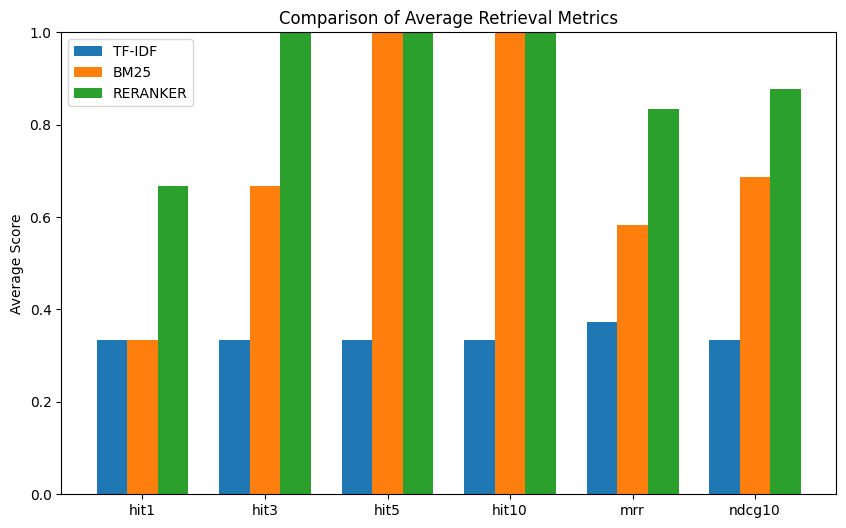

In [14]:
avg_metrics = {}
for method, metrics_dict in all_metrics.items():
    avg_metrics[method] = {metric: np.mean(values) for metric, values in metrics_dict.items()}

methods = ["TF-IDF", "BM25", "RERANKER"]
metrics = ["hit1", "hit3", "hit5", "hit10", "mrr", "ndcg10"]

values = np.array([[avg_metrics[m][metric] for m in methods] for metric in metrics])

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10,6))
for i, method in enumerate(methods):
    plt.bar(x + i*width, values[:, i], width=width, label=method)

plt.xticks(x + width, metrics)
plt.ylabel("Average Score")
plt.title("Comparison of Average Retrieval Metrics")
plt.ylim(0, 1)
plt.legend()
plt.show()

## Discussion & Conclusion

The results show that AraBERT re-ranking works well, often improving over BM25 and TF-IDF. For example, in the query “قضية الشهادة الطبية المزورة”, AraBERT ranked the true document first, while BM25 had it at rank 4 and TF-IDF much lower. Cosine similarities are high and margins from the second place are small, showing that the model understands semantic relevance.

The system is also fast because only the top 100 candidates from TF-IDF or BM25 are considered for re-ranking, which reduces computation while keeping performance high.

Overall, combining preprocessing, query expansion, and neural re-ranking gives strong results even in a large collection of 26,992 documents. Neural re-ranking effectively pushes the most relevant results to the top.